In [3]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType, Hamiltonian, TransformationType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType

In [4]:
global qubit_mapping
qubit_mapping = 'parity'# 'parity' 'jordan_wigner'
global two_qubit_reduction
two_qubit_reduction = True
global best_result
global hfmethod
hfmethod = HFMethodType.RHF
global qubitOp
global var_form
global vqe
global ferOp
global shift

In [15]:
backend = Aer.get_backend("statevector_simulator")

optimizer = COBYLA(maxiter=40)
distances = np.arange(1, 4, 11)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    charge = 1
    spin = 0
    if dist <= 1.2:
        alt=np.sqrt(dist**2 - (dist/2)**2)
        mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)
    else:
        alt=np.sqrt(dist**2 - (0.6)**2)
        mol = "H .0 .0 .0; H .0 .0 0.742; H .0 " + str(alt) + " 0.371"
    driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g',hf_method=hfmethod)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

    qubitOp, aux_ops = core.run(molecule)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=None)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    vqe_result = np.real(vqe_result_tot['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    #'''
    print("Interatomic Distance:", np.round(dist, 2), 
          "\n\tVQE calculation: ",np.real(vqe_result_tot['eigenvalue']),
          "\n\tNuclear shift: ", shift,                     
          "\n\tVQE Result: ", vqe_result)
    #'''
    #print("Interatomic Distance:", np.round(dist, 2),"\t VQE result: ", vqe_result)
    if vqe_result < min:
        min = vqe_result
        dismin = dist
        best_result = vqe_result_tot

Interatomic Distance: 1 
	VQE calculation:  -2.8685966326672943 
	Nuclear shift:  1.58753163276 
	VQE Result:  -1.2810649999072943


I plot all the calculated energies. It's clearly visible an absolute minimum

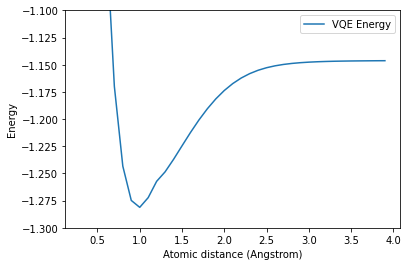

In [31]:
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.ylim([-1.3, -1.10])
plt.show()

### More VQE information

Printing all informations, parameter values, eigenalues (ecc. ecc.) for the best iteration of the VQE algorithm (bond length). 

In [33]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(best_result)

{   'cost_function_evals': 100,
    'eigenstate': array([-2.47072544e-17-2.50503678e-17j, -5.13587650e-16+1.04762132e-15j,
        9.74250767e-17+5.84305589e-18j,  6.75299668e-17-8.71818926e-17j,
        7.42656242e-17-3.18796931e-17j,  1.34184990e-16+4.71483953e-17j,
        6.35855735e-17-1.03800576e-16j,  2.00134432e-17+3.05985502e-17j,
       -2.64290994e-16+9.36105182e-16j,  9.90361790e-01-7.75315393e-15j,
       -2.12957491e-04-1.54045816e-16j,  4.70628360e-16+6.17301404e-16j,
        3.50948029e-04+2.04718185e-16j,  3.51860912e-16+6.17390369e-16j,
       -4.88322697e-17+1.04572445e-16j,  6.09134065e-17-7.97906743e-17j,
        1.81634892e-17-6.17090616e-17j,  5.72932921e-04+9.77725394e-17j,
       -9.80310810e-02+5.14093087e-16j, -2.53132680e-17-1.33344399e-16j,
       -4.54211857e-05-3.45382068e-17j,  3.28055215e-17-7.87451973e-18j,
       -4.20754521e-17-6.06443049e-17j, -7.40850207e-17-8.26667500e-19j,
        4.17064836e-17-3.57640637e-17j,  4.76012098e-16+5.59087371e-16j,
 

H3+ hamiltonian, qubit mapped and simplified.

In [34]:
pp.pprint(ferOp.mapping(qubit_mapping).simplify().print_details())

('IIIIII\t(-1.3710914596000712+0j)\n'
 'IIIIIZ\t(0.1729921938896205+0j)\n'
 'IIIIYY\t(0.0008990120420158368+0j)\n'
 'IIIIXX\t(0.0008990120420158368+0j)\n'
 'IIIIZI\t(0.04214794823912783+0j)\n'
 'IIIZII\t(-0.2210365842753662+0j)\n'
 'IIZIII\t(0.1729921938896204+0j)\n'
 'IYYIII\t(0.0008990120420158353+0j)\n'
 'IXXIII\t(0.0008990120420158353+0j)\n'
 'IZIIII\t(0.04214794823912789+0j)\n'
 'ZIIIII\t(-0.22103658427536618+0j)\n'
 'IIIIZZ\t(0.034221120216452454+0j)\n'
 'IIIZIZ\t(0.12058531852223081+0j)\n'
 'IIIZYY\t(0.0013731770918290144+0j)\n'
 'IIIZXX\t(0.0013731770918290144+0j)\n'
 'IIZIIZ\t(0.1685123267806977+0j)\n'
 'IIZIYY\t(0.0021623381850934026+0j)\n'
 'IIZIXX\t(0.0021623381850934026+0j)\n'
 'IXXIIZ\t(0.0021623381850934026+0j)\n'
 'IYYIIZ\t(0.0021623381850934026+0j)\n'
 'IXXIYY\t(6.706703281803655e-05+0j)\n'
 'IYYIYY\t(6.706703281803655e-05+0j)\n'
 'IXXIXX\t(6.706703281803655e-05+0j)\n'
 'IYYIXX\t(6.706703281803655e-05+0j)\n'
 'XZXYZY\t(0.04539056492862682+0j)\n'
 'YZYYZY\t(0.0453905649

UCCSD variational form just considers these single and double excitations (spin and number of particles conservation):

In [35]:
print(var_form.single_excitations)
print(var_form.double_excitations)

[[0, 1], [0, 2], [3, 4], [3, 5]]
[[0, 1, 3, 4], [0, 1, 3, 5], [0, 2, 3, 4], [0, 2, 3, 5]]


## Exact solution (e confronto con VQE)

In [5]:
def vqe_function(geometry, basis):
    backend = Aer.get_backend("statevector_simulator")
    optimizer = COBYLA(maxiter=40)
    
    two_qubit_reduction = True
    qubit_mapping = 'parity'
    
    charge = 1
    spin = 0
    driver = PySCFDriver(atom = geometry,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis=basis,hf_method=HFMethodType.RHF)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

    qubitOp, aux_ops = core.run(molecule)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=None)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    return np.real(vqe_result_tot['eigenvalue'] + shift)

In [6]:
import numpy as np
from pyscf import gto,scf,ao2mo,mp,cc,fci,tools
import matplotlib.pyplot as plt

dist = np.arange(0.3, 3.5, .1)
alt=np.sqrt(dist**2 - (dist/2)**2)
basis = 'sto-6g' #'sto-6g' '6-31g' 'cc-pvdz' 'aug-cc-pvdz' ,...


energies = {}

energies["HF"] = []
energies["FCI"] = []
#energies["MP2"] = []
#energies["CCSD"] = []
#energies["VQE"] = []


for i in range(len(dist)):
    
    geometry = "H .0 .0 .0; H .0 .0 " + str(dist[i]) + "; H .0 " + str(alt[i]) + " " + str(dist[i]/2)
    mol = gto.M(atom=geometry,charge=1,spin=0,basis=basis,symmetry=True,verbose=0)
    
    mf  = scf.RHF(mol)
    Ehf = mf.kernel() #<- chiamando il kernel otteniamo l'energia calcolata dal metodo
    energies["HF"].append(Ehf)
    
    fci_h3 = fci.FCI(mf)  #<- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_fci = fci_h3.kernel()[0]
    energies["FCI"].append(e_fci)
    '''
    mp2   = mp.MP2(mf)
    e_mp2 = mp2.kernel()[0]
    e_mp2 += Ehf # <- questa linea è necessaria perchè MP2 generalmente mostra l'energia di differenza con HF
    energies["MP2"].append(e_mp2)
    
    ccsd_h3 = cc.CCSD(mf)
    e_ccsd  = ccsd_h3.kernel()[0]
    e_ccsd += Ehf # <- questa linea è necessaria perchè CCSD generalmente mostra l'energia di differenza con HF
    energies["CCSD"].append(e_ccsd)
    
    
    vqe_result = vqe_function(geometry, basis='sto-6g')
    energies["VQE"].append(vqe_result)
    '''

In [7]:
energies

{'HF': [0.805610070387738,
  -0.22321436431273423,
  -0.7367229629714385,
  -1.007104547434058,
  -1.149785629827218,
  -1.220720644951825,
  -1.2494674834990795,
  -1.2526503411788528,
  -1.2400693045269737,
  -1.2177264183217726,
  -1.189435384895112,
  -1.157714054111959,
  -1.1242888776973972,
  -1.0903826899967242,
  -1.0568801388727016,
  -1.0244247396564663,
  -0.9934786770804004,
  -0.9643624774246218,
  -0.9372833074829038,
  -0.9123563277190746,
  -0.8896216436058548,
  -0.8690585548963077,
  -0.8505982043862217,
  -0.834135171241577,
  -0.8195381100874414,
  -0.8066592862527463,
  -0.7953427959887899,
  -0.7854313231523352,
  -0.776771396019425,
  -0.7692172166288161,
  -0.7626332151392136,
  -0.7568955278185283],
 'FCI': [0.7930249944681096,
  -0.23748138680009934,
  -0.7527805858030656,
  -1.0251057217763129,
  -1.1699429398436911,
  -1.2433092266100079,
  -1.2748268385778982,
  -1.281187999425128,
  -1.2722647705355452,
  -1.2541321018359217,
  -1.2306719129030712,
  -1.2

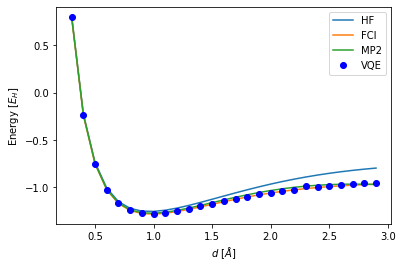

In [12]:
for (method,E) in energies.items():
    if (method == "VQE"):
        plt.plot(dist,E,'bo',label=method)
    #elif (method == "FCI"):
    #    plt.plot(dist,E,'bo',label=method)
    else:
        plt.plot(dist,E,label=method)
    
#plt.plot(alt,energies["HF"])
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[E_H]$")
#plt.ylim([-1.3, -1.1])
#plt.xlim([0.5, 1.50])
plt.legend()

plt.savefig('/mnt/c/Users/Rodolfo/Desktop/figura.png')
plt.show()

## Quantum hardware

In [59]:
from qiskit import IBMQ, execute
from qiskit.aqua import QuantumInstance
from qiskit.providers.ibmq import least_busy

provider = IBMQ.load_account()

In [40]:
#least_busy_device = least_busy(provider.backends(simulator=False,filters=lambda x: x.configuration().n_qubits > 4))
least_busy_device = provider.get_backend("ibmq_santiago")
print("Running on current least busy device: ", least_busy_device)

optimizer = COBYLA(maxiter=10)

charge = 1
dist = 1
alt=np.sqrt(dist**2 - (dist/2)**2)
spin = 0

mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)

driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g',hf_method=hfmethod)
    
molecule = driver.run()
    
shift = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_orbitals = molecule.num_orbitals
num_spin_orbitals = num_orbitals*2
    
    
core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

qubitOp, aux_ops = core.run(molecule)
        
initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction)
    
init_parm = [-0.0015684975005684477,-0.01035528907693455,-0.008109583889823179,-0.0011484985977060682,-0.08378090013006043,-0.006784611145360888,-0.010569271966603446,-0.09877149769063708] #np.zeros(var_form.num_parameters)
vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)

quantum_instance=QuantumInstance(backend=least_busy_device,shots=8000)

vqe_result_tot = vqe.run(quantum_instance)

Running on current least busy device:  ibmq_santiago


In [41]:
vqe_result_tot #(quantum hardware)

{'optimal_parameters': {Parameter(θ[0]): 1.0651577717101108, Parameter(θ[1]): 1.0415929492831026, Parameter(θ[2]): -0.40922477301535704, Parameter(θ[3]): 1.1282029085679137, Parameter(θ[4]): -0.359321120352727, Parameter(θ[5]): -0.5319567514957101, Parameter(θ[6]): -0.21037454524904495, Parameter(θ[7]): -0.7495967175873313}, 'optimal_point': array([ 1.06515777,  1.04159295, -0.40922477,  1.12820291, -0.35932112,
       -0.53195675, -0.21037455, -0.74959672]), 'optimal_value': -1.9411991146756826, 'optimizer_evals': 10, 'optimizer_time': 3142.5636843999964, 'eigenvalue': (-1.9411991146756826+0j), 'eigenstate': {'0000': 420, '0001': 440, '0010': 389, '0011': 366, '0100': 548, '0101': 549, '0110': 543, '0111': 557, '1000': 462, '1001': 438, '1010': 448, '1011': 405, '1100': 644, '1101': 615, '1110': 574, '1111': 602}, 'cost_function_evals': 10}

In [63]:
vqe_result_tot (statevector simulator)

{'optimal_parameters': {Parameter(θ[0]): -0.0015684975005684477, Parameter(θ[1]): -0.01035528907693455, Parameter(θ[2]): -0.008109583889823179, Parameter(θ[3]): -0.0011484985977060682, Parameter(θ[4]): -0.08378090013006043, Parameter(θ[5]): -0.006784611145360888, Parameter(θ[6]): -0.010569271966603446, Parameter(θ[7]): -0.09877149769063708}, 'optimal_point': array([-0.0015685 , -0.01035529, -0.00810958, -0.0011485 , -0.0837809 ,
       -0.00678461, -0.01056927, -0.0987715 ]), 'optimal_value': -2.8681715378006754, 'optimizer_evals': 40, 'optimizer_time': 8.714432399952784, 'eigenvalue': (-2.8681715378006754+0j), 'eigenstate': array([-1.03545331e-02-6.60818971e-05j, -6.29404242e-16+4.51191269e-16j,
       -1.56841231e-03-1.00094963e-05j,  9.91452677e-01+6.32738081e-03j,
       -1.04466590e-02-6.66698380e-05j, -2.02482503e-17+2.52921131e-17j,
       -8.36611463e-02-5.33919514e-04j, -8.10888510e-03-5.17503307e-05j,
       -5.49990461e-17+2.38491081e-17j, -4.33020227e-17+1.88546955e-17j,
  

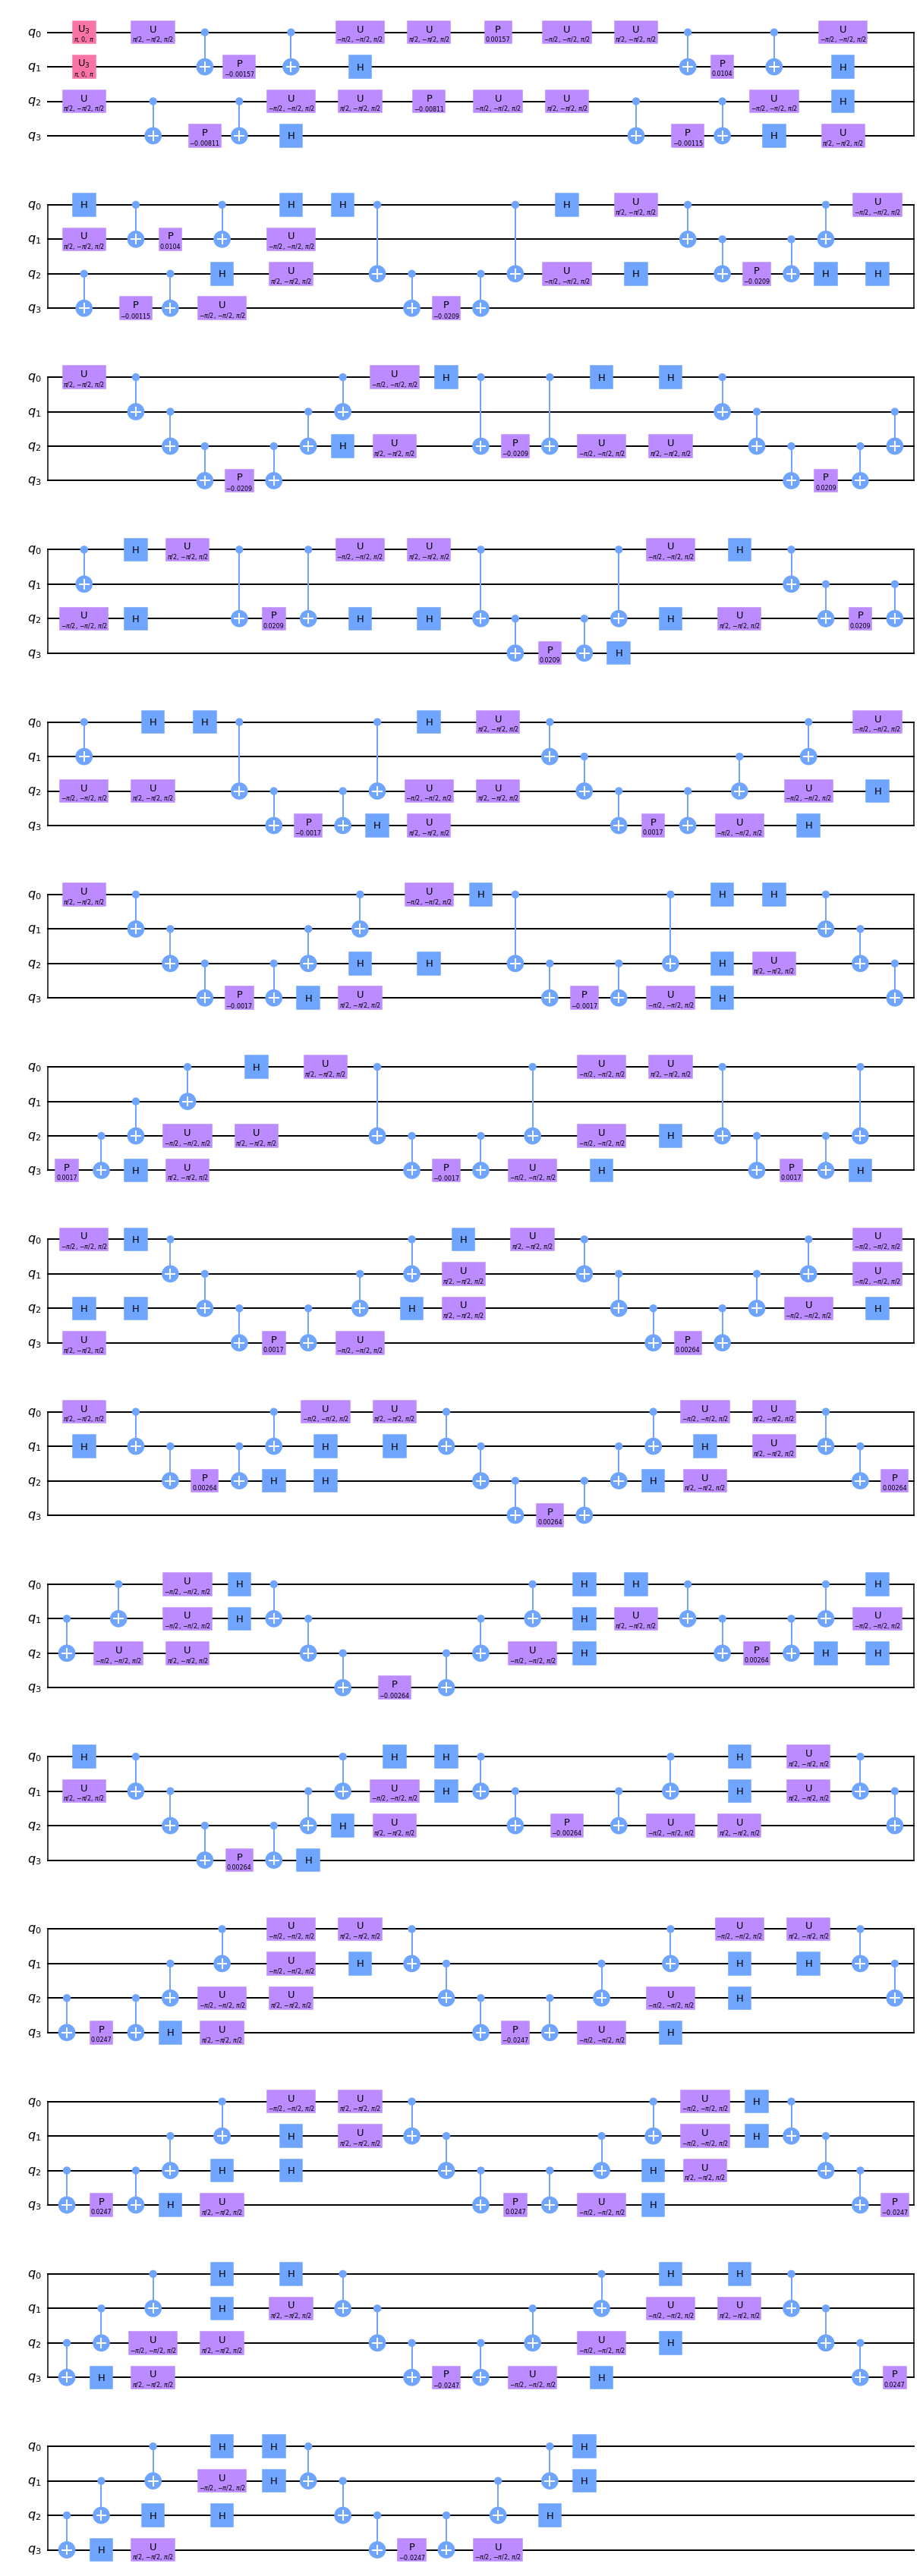

In [17]:
from qiskit.tools.visualization import circuit_drawer

init_parm = [-0.0015684975005684477,-0.01035528907693455,-0.008109583889823179,-0.0011484985977060682,-0.08378090013006043,-0.006784611145360888,-0.010569271966603446,-0.09877149769063708] #np.zeros(var_form.num_parameters)
circuit_to_decompose = var_form.construct_circuit(init_parm)
circuit_drawer(circuit_to_decompose.decompose(),
               output='mpl', filename = '/mnt/c/Users/Rodolfo/Desktop/figura.png')

In [31]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.4',
 'qiskit-aer': '0.7.6',
 'qiskit-ignis': '0.5.2',
 'qiskit-ibmq-provider': '0.12.2',
 'qiskit-aqua': '0.8.2',
 'qiskit': '0.24.1'}